# **Tutorial 2** - Understanding the PIRLS dataset

Welcome in the next part of our tutorials for Global Data Science Challenge 2024. Today, we embark on a comprehensive exploration of our dataset for this year's GDSC, featuring the PIRLS 2021 dataset.
A solid understanding of the data is arguably the most important part of *any* data science project. The impact of data on the final results is usually higher than the impact of the choice of algorithm. The [data-centric AI](https://datacentricai.org/) is a great start to get deeper into the topic.

This tutorial is structured into three primary components: a video, a website, and this notebook. To begin, I recommend watching the [PIRLS 2021 video](https://youtu.be/jUv1QowWmqI?feature=shared), which provides a solid foundation on what this study encompasses. Following the video, visit the [PIRLS 2021 website](https://pirls2021.org/) to delve deeper and discover additional information about the study. After engaging with these resources, you'll be well-prepared to navigate through this notebook.

*If you're not watching our tutorial video and you are only reading this notebook, now is the perfect time watch [PIRLS 2021 video](https://youtu.be/jUv1QowWmqI?feature=shared) and browse through [PIRLS 2021 website](https://pirls2021.org/). Completing these steps is crucial for a thorough understanding of the study, which, in turn, will enhance your ability to follow along with the notebook. I strongly encourage you to familiarize yourself with the study before proceeding, to ensure a smooth and informed learning experience.*

The goal of the GDSC is to build AI agents that automatically answer complex questions about educational topics, utilizing the PIRLS 2021 data. 
This notebook is crafted to showcase the complexity of SQL queries that LLMs (Large Language Models) will ingeniously construct to navigate the dataset's depths. Moreover, it's designed to empower you with strategies for independently discovering the data you find most compelling. By illustrating both the advanced SQL capabilities required by LLMs and guiding you on how to embark on your data exploration journey, we aim to provide a comprehensive understanding of effective query formulation.

## Agenda

1. [Set up the environment](#set-up-the-environment) - Provides all the essential functions needed to configure the environment for developing and executing queries

2. [The database schema](#the-database-schema) - Describes the structure of the relational database
    - [The database overview](#the-database-overview) - Offers a high-level overview of the database schema, explaining the organization and relationships between different tables.

    - [Tables about student questionnaires](#tables-about-student-questionnaires) - Delves into the specifics of the tables related to student questionnaires.

    - [Tables about student achievement scores](#tables-about-student-achievement-scores) - Explores the specifics of the tables related to student achievement scores:

        - [Clarification - Student Score Entries](#clarification---student-score-entries) - Provides a detailed explanation of the `Student Score Entries` table, including the types of scores recorded and the significance of average and standard deviation metrics.

        - [Clarification - Benchmarks](#clarification---benchmarks) - Explains the `Benchmarks` table, focusing on how benchmarks are set for different scores and what they indicate about student performance.
    
    - [Tables about school, home, and curriculum questionnaires](#tables-about-school-home-and-curriculum-questionnaires) - Highlights key points for the tables related to school, home, and curriculum questionnaires.

    - [Table about teacher questionnaires](#table-about-teacher-questionnaire) - Highlights key points for the tables related to teacher questionnaires.
        
3. [Querying the database](#querying-the-database) - Demonstrates how to effectively extract meaningful insights from the database
    - [Show available tables](#show-available-tables)
    
    - [Understanding the content of a table](#understanding-the-content-of-a-table)

    - [Example graphs for visualizing data](#example-graphs-for-visualizing-data)

    - [What types of questions to expect during the challenge](#what-types-of-questions-to-expect-during-the-challenge)
    
4. [Conclusion](#conclusion) - Summarizes what we learned and how to proceed
  
5. [Appendix](#appendix) - Additional resources

    - [More example questions with SQL queries](#more-example-questions-with-sql-queries),

    - [VS Code](#vs-code) - Shows how to set up a notebook in the VS Code IDE

        - [Data Wrangler](#data-wrangler) - Presents the VS Code extension and how to install it. This is optional but highly recommended.
    

## Set up the environment

Firstly we install and import necessary python modules.

In [ ]:
# Installing necessary modules

!pip install psycopg2-binary pandas seaborn matplotlib

In [ ]:
import psycopg2 # module for connecting to a PostgreSQL database
import pandas as pd  # module for data manipulation and analysis

import seaborn as sns # library for visualization of data
import matplotlib.pyplot as plt # library for visualization of data

pd.set_option('display.max_colwidth', None) # display all the contents of a column

We define the login information for the database ...

In [7]:
DB_ENDPOINT = 'INSERT DB URL HERE'
DB_PORT = '5432'
DB_USER = 'INSERT USER HERE'
DB_PASSWORD ='INSERT PASSWOERD HERE'
DB_NAME ='postgres'

... and some helper function  for database connectivity, query execution, and related operations. We'll use them later.

In [8]:
def create_connection() -> psycopg2.extensions.connection:
    """
    Creates a connection to the PostgreSQL database. Uses the global variables DB_ENDPOINT, DB_PORT, DB_USER, DB_PASSWORD, DB_NAME.

    Returns:
        psycopg2.extensions.connection: A connection object to the PostgreSQL database.
    """
    return psycopg2.connect(
        host=DB_ENDPOINT,
        port=DB_PORT,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME
    )

def get_from_db(connection: psycopg2.extensions.connection, query: str) -> pd.DataFrame:
    """
    Executes the given SQL query on the provided database connection and returns the result as a pandas DataFrame.

    Parameters:
        connection (psycopg2.extensions.connection): The database connection object.
        query (str): The SQL query to execute.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the result of the query.

    Raises:
        psycopg2.Error: If there is an error executing the query.
    """
    try:
        with connection:
            with connection.cursor() as cursor:
                cursor.execute(query)
                result = cursor.fetchall()
                column_names = [desc[0] for desc in cursor.description]
    except psycopg2.Error as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame()

    return pd.DataFrame(result, columns=column_names)

Almost done! But before our SQL journey begins, we need to establish a connection with the database.

In [9]:
connection = create_connection()

The code cell below serves as a test to verify that you have successfully established a connection with the database and are able to execute a data selection query. If it executes without any errors and displays a dataframe table, then your setup is correctly configured.

In [10]:
query_connection_check = '''
        SELECT * FROM Countries
'''
query_connection_check_df = get_from_db(connection, query_connection_check)
query_connection_check_df

,country_id,code,name,benchmark,testtype
0,36,AUS,Australia,False,paper
1,40,AUT,Austria,False,paper
2,31,AZE,Azerbaijan,False,paper
3,48,BHR,Bahrain,False,paper
4,956,BFL,Belgium (Flemish),False,digital
...,...,...,...,...,...
60,926,ENG,United Kingdom,False,paper
61,7841,ADU,"Dubai, United Arab Emirates",True,digital
62,7842,AAD,"Abu Dhabi, United Arab Emirates",True,digital
63,8,ALB,Albania,False,paper



Phew, we've finally managed to configure our environment! Now, let's dive into the exciting part—exploring and playing with our database!

## The Database Schema

*I highly recommend opening the database schema in a separate window, so it's always within easy reach without the need to constantly scroll up and down.*

### The database overview

The dataset is pretty massive and quite complex. The biggest subtable has over 27 millions rows! But fear not! We've done the heavy lifting for you and organized the data into a more convenient structure. We've uploaded the data to a relational database based on this schema. The database we're utilizing is hosted on AWS's cloud infrastructure, specifically utilizing Aurora. While it may seem daunting at first glance, the structure is actually quite straightforward and I will walk you through it step by step.

As you can see, the diagram is quite colorful. Each color represents a different category of data collected in this dataset. We have sections dedicated to students, schools, teachers, homes, curricula, and much more. The structure for each section is quite similar to the others, so once you understand the data flow for one part, you shouldn't have any trouble understanding the rest.


![title](../images/t2_db_schema.png)

### Tables about student questionnaires

Alright, let's start with the students, as they are the core of our study. All the green boxes in the diagram above are related to them. To simplify things, we've divided the green section into smaller parts: one for the questionnaire and the other for students' achievement scores. Just to jog your memory, the questionnaire part contains data on answers to questions like "What is your gender?" and "What do you think about school?". The part about achievement scores contains data on students' results from tests measuring their reading skills.

Every block in this diagram represents a table. `Students` is the main table for the whole dataset, so we will start with it. Each student in the `Students` table has 
- a primary key (PK) **Student_ID** and several foreign keys (FK), such as 
- **Country_ID**, indicating the student's country of origin, 
- **School_ID**, indicating the school the student attends, and 
- **Home_ID**, indicating the student's parents or guardians.

To understand more about each **Country_ID**, you can cross-reference it with the `Countries` table using the **Country_ID** key. In the `Countries` table, you'll find additional information such as the country's name, code, whether it's benchmarking, and the type of test in which the country participated.

Data about student questionnaires are split into two tables. The `Student Questionnaire Entries` table lists the questions that the students were asked. It consists of 
- **Code**, which is the primary key for each particular question, 
- **Question**, which is question itself, and 
- **Type**, which provides additional info to help find questions of interest. 

The `Student Questionnaire Answers` table contains the aswers to the questions. It has **Code**, which indicates for which question this answer is. To identify unique element of this table it is necessary to use compound key which consist of **Student_ID** and question **Code**. Last field is **Answer** for that question. 

These three tables combined together make it possible to find answers to question of our interest for particular student. 



SoFor example, if you want to check how student 51250010201 answered question ASBG01, you need to get the **Student_ID** for the student 51250010201 from table `Students` and get **Code** for question ASBG01 from table `Student Questionnaire Entries` then connect those two keys and look for the **Answer** from table `Student Questionnaire Answers`:

```sql
SELECT * FROM StudentQuestionnaireAnswers
WHERE Student_ID = 51250010201 AND Code='ASBG01';
```

In [14]:
query_demo_1 = '''
        SELECT * FROM StudentQuestionnaireAnswers
        WHERE Student_ID = 51250010201 AND Code='ASBG01';
'''
demo_1_df = get_from_db(connection, query_demo_1)
demo_1_df

,student_id,code,answer
0,51250010201,ASBG01,Boy


Cany you guess what the questions was? You can look it up via

In [15]:
query_demo_2 = '''
        SELECT * FROM StudentQuestionnaireEntries
        WHERE Code='ASBG01';
'''
demo_2_df = get_from_db(connection, query_demo_2)
demo_2_df

,code,question,type
0,ASBG01,Which of these describes you sex,About you


In order to gather both questions and answers for every student, you can simply join the three relevant tables together like so

```sql
SELECT S.Student_ID, E.Code, E.Question, A.Answer, E.Type FROM Students AS S
LEFT JOIN StudentQuestionnaireAnswers AS A ON S.Student_ID = A.Student_ID
LEFT JOIN StudentQuestionnaireEntries AS E ON A.Code = E.Code
LIMIT(750);
```

This query efficiently combines data from the `Students`, `StudentQuestionnaireAnswers`, and `StudentQuestionnaireEntries` tables. By using `LEFT JOINs`, it ensures that you get all students listed, even those who might not have any answers recorded. The ``LIMIT 750`` part is just there to keep the result set manageable by showing only the first 750 records.

In [16]:
query_demo_3 = '''
        SELECT S.Student_ID, E.Code, E.Question, A.Answer, E.Type FROM Students AS S
        LEFT JOIN StudentQuestionnaireAnswers AS A ON S.Student_ID = A.Student_ID
        LEFT JOIN StudentQuestionnaireEntries AS E ON A.Code = E.Code
        LIMIT(750);
'''
demo_3_df = get_from_db(connection, query_demo_3)
demo_3_df

,student_id,code,question,answer,type
0,62050010602,ASBG01,Which of these describes you sex,Girl,About you
1,62050010602,ASBG03,How often do you speak <language of test> at home,I always speak <language of test> at home,About you
2,62050010602,ASBG04,"About how many books are there in your home? (Do not count magazines, newspapers, or your school books.)",Enough to fill one shelf (11–25 books),About you
3,62050010602,ASBG05A,(Do you have any of these things at your home) A shared computer or tablet that you can use,Yes,About you
4,62050010602,ASBG05B,(Do you have any of these things at your home) Study desk/table for your use,Yes,About you
...,...,...,...,...,...
745,62050010612,ASBR08B,(How well do you read? Tell how much you agree with each of these statements.) Reading is easy for me,Agree a little,What you think about reading
746,62050010612,ASBR08C,(How well do you read? Tell how much you agree with each of these statements.) I have trouble reading stories with difficult words,Agree a little,What you think about reading
747,62050010612,ASBR08D,(How well do you read? Tell how much you agree with each of these statements.) Reading is harder for me than for many of my classmates,Agree a little,What you think about reading
748,62050010612,ASBR08E,(How well do you read? Tell how much you agree with each of these statements.) Reading is harder for me than any other subject,Disagree a lot,What you think about reading


*Heads up! Some tables are packed with a ton of records. Hit them with a `SELECT * FROM` and you're asking for a kernel crash party. So, let's not. Always slap a `LIMIT` on your SQL queries, unless you're dead sure the table's as lightweight as `Countries`.*

### Tables about student achievement scores

Moving on to the next segment, we're diving into students' achievement scores. The twist here is that we're focusing on reading scores instead of questionnaire answers. The setup is pretty similar to what we've seen before. In the `StudentScoreEntries` table, you'll find the **Code** for each score, the **Name** of the score, and a **Type** field that gives you extra clues to pinpoint the scores you're really interested in. Over in the `StudentScoreResults` table, there's also a **Code**, which tells you which score the result belongs to. To uniquely identify records in this table, you'll need to use a combo of **Student_ID** and the score **Code**. And, of course, there's the **Score** field that shows the actual score.

By meshing these three tables together, you can easily track down the reading score results for any student you're curious about.

So if you want to check how student 51250010201 performed on score ASRREA_avg, you need to get the **Student_ID** for the student 51250010201 from table `Students` and get **Code** for score ASRREA_avg from table `StudentScoreEntries` then connect those two keys and look for the **Score** from table `StudentScoreResults`. 

```sql
SELECT * FROM StudentScoreResults
WHERE Student_ID = 51250010201 AND Code='ASRREA_avg';
```

In [22]:
query_demo_4 = '''
        SELECT * FROM StudentScoreResults
        WHERE Student_ID = 51250010201 AND Code='ASRREA_avg';
'''
demo_4_df = get_from_db(connection, query_demo_4)
demo_4_df

,student_id,code,score
0,51250010201,ASRREA_avg,361.845158


*Note: If you're unsure about the meaning of these scores, don't worry—they will be explained in [the next section](#clarification---student-score-entries).*

In order to gather both names of scores and score results for every student, you can simply join the three relevant tables together like so:

```sql
SELECT S.Student_ID, E.Code, E.Name, R.Score, E.Type FROM Students AS S
LEFT JOIN StudentScoreResults AS R ON S.Student_ID = R.Student_ID
LEFT JOIN StudentScoreEntries AS E ON R.Code = E.Code
LIMIT(100);
```

This query is your golden ticket to fetching the student IDs, score codes, score names, the scores themselves, and the score types. We're using `LEFT JOINs` to make sure no student gets left behind, even if they don't have a score recorded. And we're keeping things light by only grabbing the first 100 rows.

In [23]:
query_demo_5 = '''
        SELECT S.Student_ID, E.Code, E.Name, R.Score, E.Type FROM Students AS S
        LEFT JOIN StudentScoreResults AS R ON S.Student_ID = R.Student_ID
        LEFT JOIN StudentScoreEntries AS E ON R.Code = E.Code
        LIMIT(100);
'''
demo_5_df = get_from_db(connection, query_demo_5)
demo_5_df

,student_id,code,name,score,type
0,850010101,ASRIIE_avg,"Interpreting, Integrating and Evaluating (average)",590.190764,Comprehension Process
1,850010101,ASRIIE_std,"Interpreting, Integrating and Evaluating (standard deviation)",56.102926,Comprehension Process
2,850010101,ASRINF_avg,Acquire and Use Information (average),570.698342,Reading Purpose
3,850010101,ASRINF_std,Acquire and Use Information (standard deviation),38.658939,Reading Purpose
4,850010101,ASRLIT_avg,Literary Experience (average),575.896820,Reading Purpose
...,...,...,...,...,...
95,850010110,ASRLIT_std,Literary Experience (standard deviation),51.495403,Reading Purpose
96,850010110,ASRREA_avg,Overall reading score (average),569.400622,Reading Purpose and Comprehension Process
97,850010110,ASRREA_std,Overall reading score (standard deviation),52.165494,Reading Purpose and Comprehension Process
98,850010110,ASRRSI_avg,Retrieving and Straightforward Inferencing (average),556.596568,Comprehension Process


Told ya! Once you've got the first part down, everything else is smooth sailing!

#### Clarification - Student Score Entries

This section is an ideal place to clarify the contents of the `Student Score Entries table`, as its details might not be immediately intuitive. Let's dive in. To ensure complete clarity, we'll begin by displaying the table content with an SQL query.

In [24]:
query_score_entries = '''
        SELECT * FROM StudentScoreEntries;
'''
score_entries_df = get_from_db(connection, query_score_entries)
score_entries_df

,code,name,type
0,ASRREA_avg,Overall reading score (average),Reading Purpose and Comprehension Process
1,ASRREA_std,Overall reading score (standard deviation),Reading Purpose and Comprehension Process
2,ASRLIT_avg,Literary Experience (average),Reading Purpose
3,ASRLIT_std,Literary Experience (standard deviation),Reading Purpose
4,ASRINF_avg,Acquire and Use Information (average),Reading Purpose
5,ASRINF_std,Acquire and Use Information (standard deviation),Reading Purpose
6,ASRIIE_avg,"Interpreting, Integrating and Evaluating (average)",Comprehension Process
7,ASRIIE_std,"Interpreting, Integrating and Evaluating (standard deviation)",Comprehension Process
8,ASRRSI_avg,Retrieving and Straightforward Inferencing (average),Comprehension Process
9,ASRRSI_std,Retrieving and Straightforward Inferencing (standard deviation),Comprehension Process


If you're puzzled by those unusual abbreviations, don't worry, everything will be clear in a minute.

The test was segmented into four distinct sections, each designed to assess a different reading skill set:
- **Literary Experience** (ASRLIT)
- **Acquire and Use Information** (ASRINF)
- **Interpreting, Integrating and Evaluating** (ASRIIE)
- **Retrieving and Straightforward Inferencing** (ASRRSI)

To evaluate these skills, four specific scores are calculated, with each score reflecting performance in a particular area of the test. There is also a fifth score **Overall Reading Score (ASRREA)**  that aggregates the overall performance across the entire test, primarily used to gauge a student's reading ability. Typically, you'll rely on this **Overall Reading Score** to determine a student's reading capabilities, meaning initially, you may not need to concentrate as much on the other four scores.

Each score is associated with two critical metrics: the average and the standard deviation. The average score distills the complex outcomes of the test into a single, more comprehensible value. Thus, the average should be viewed as a straightforward indicator of a student's result for either the entire test or a specific part of it. The standard deviation, on the other hand, quantifies the variability in scores, providing insight into the consistency of a student's performance.

There is also a **Type** column indicating whether a score focuses on assessing a skill related to reading purpose or is more focused on the comprehension process.

#### Clarification - Benchmarks

Additionally we have a table `Benchmarks` which is not connected to any other table but it stores data about benchmarks in PIRLS study. 

In [25]:
query_benchmarks = '''
        SELECT * FROM Benchmarks;
'''
benchmarks_df = get_from_db(connection, query_benchmarks)
benchmarks_df

,benchmark_id,score,name
0,1,400,Low International Benchmark
1,2,475,Intermediate International Benchmark
2,3,550,High International Benchmark
3,4,625,Advanced International Benchmark


A benchmark is essentially a marker or a standard used to measure something - in this case, reading abilities. Think of it as the minimum score you need to reach a certain level. It's like a ladder: if you reach the top rung (the highest benchmark), you've also stepped on all the rungs below it. So, if a student scores an average of 700 on the ASRREA test, they've not only hit the top mark, the Advanced International Benchmark, but they've also automatically met the criteria for the Low, Intermediate, and High benchmarks. It's a way of saying:
> "If you're good enough for the top, you're definitely good enough for the levels leading up to it."

Note that this means that our student from the previous example with the id 51250010201 didn't even reach the Low International Benchmark. 

**Excercise:**
- Investigate the context of student 51250010201 and come up with hypothesis how their reading level could be improved.


### Tables about school, home and curriculum questionnaires

I'll spare you the detailed explanation of the table structures but highlight a couple of key points for navigating the data:
- Every variable_ID such as **School_ID**, **Home_ID** etc. are consistent across all tables, allowing for direct connections, such as from the `Student` table to the `School Questionnaire Answers`.
- **Curriculum_ID** and **Country_ID** are interchangeable, enabling direct links from the `Student` table to the `Curricula Questionnaire Answers` using just the **Country_ID**.

### Table about teacher questionnaire

The `Teacher Questionnaire Answers` table stands out as the only one that does not offer a direct connection from the `Students` table. This is because a student may have multiple teachers, making a direct link impractical in this context.

### Key Insights

This first part showed you the overall structure of the dataset. Your key takeaways should be:

- **Complex Database Structure**: The database's complexity underscores the importance of grasping its structure and relationships. Familiarizing yourself with its intricacies is key to navigating and utilizing it effectively.

- **Large Datasets**: Some tables contain a vast number of records, indicating a rich dataset that could provide comprehensive insights but may also require efficient querying techniques to manage effectively.

- **Varied Questionnaire Responses**: The database accommodates diverse types of responses to questionnaire questions, highlighting the need for flexible data handling and analysis strategies to interpret these varied data points accurately.

- **SQL Queries for Data Retrieval**: To extract information, leveraging SQL queries with commands like `JOIN` and `WHERE` is essential. This approach allows for the combination and filtering of data across tables to meet specific analysis needs.

- **Focus on ASSREA_avg Score**: The ASSREA_avg score, representing the average overall reading score, is a primary metric for assessing student reading abilities. This focus underscores the importance of literacy metrics in evaluating educational outcomes.

### Exercises

Here's a practical exercise to enhance your skills in querying information from the database with SQL. The objective is to locate a specific question of interest and gather all unique responses to it. Follow the guided steps below:

1. **Retrieve COVID-19 Related Records**: Start by fetching entries from the `School Questionnaire Entries` table that are associated with the **COVID-19 Pandemic**. This step helps narrow down our focus to pandemic-related questions.

2. **Identify the Relevant Question Code**: After reviewing the questions retrieved in the previous step, identify and note the **Code** for the question that inquires about the number of weeks normal primary school operations were impacted by the COVID-19 Pandemic. This code will be crucial for filtering responses in the next steps.

3. **Filter Responses by Question Code**: With the question code in hand, proceed to filter records in the `School Questionnaire Answers` table. Ensure you're only selecting entries that respond to our identified question regarding the pandemic's impact on school operations.

4. **Extract Unique Answers**: For the final step, refine your query to return only distinct values of **Answer** column from the filtered responses. This will provide a clear view of all unique answers given to the question, offering insights into the varied impacts of the pandemic on schools.

By completing these steps, you'll gain valuable practice in extracting and analyzing specific data points from a complex database, enhancing your SQL querying skills. If you're stuck take a look at the next sections and/or ask you favourite LLM to help you!

In [13]:
query_exercise = '''
        Here is the place for your sql query
'''
# Uncomment the lines below to check if your query is working properly

# exercise_df = get_from_db(connection, query_exercise)
# exercise_df

## Querying the database

In this section, we're not going to walk through every table's content. Instead, we're arming you with the tools to dig out the gems that spark your interest. Go ahead, tweak our code, throw in your queries, jazz it up with your markdowns - make it yours. And hey, if there's a little voice in your head worrying about messing things up, just clone this notebook and experiment away. No stress!

### Show available tables

Here is a listing of all tables within our database schema, including a count of the number of rows present in each table.

In [26]:
query = '''
        SELECT table_name FROM information_schema.tables
        WHERE table_schema='public'
        '''
table_names_df = get_from_db(connection, query)

# Initialize an empty list to store the results
results = []

# Iterate over the table names, count the rows, and append the results
for table_name in table_names_df['table_name']:
    count_query = f"SELECT COUNT(*) as row_count FROM {table_name}"
    row_count_df = get_from_db(connection, count_query)
    row_count = row_count_df.iloc[0]['row_count']
    results.append({'Table Name': table_name, 'Number of Rows': row_count})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Number of Rows')

# Display the DataFrame
results_df

,Table Name,Number of Rows
2,benchmarks,4
19,studentscoreentries,10
0,curricula,60
13,countries,65
9,schoolquestionnaireentries,80
7,studentquestionnaireentries,80
1,homequestionnaireentries,87
16,curriculumquestionnaireentries,115
17,teacherquestionnaireentries,163
15,curriculumquestionnaireanswers,4800


Just like I hinted before, some of our tables are absolutely jam-packed with data. Take the `Student questionnaire answers` table, for example—it's a behemoth with almost 30 million rows! It's a clear sign of the massive amount of information we're playing with here.

### Show countries

#### Understanding a table structure

Here's a straightforward query example that reveals the columns in our table along with their data types.
This simple query is quite useful for quickly understanding the structure of our table, including the types of data each column holds. It's a great starting point for getting familiar with our dataset.

E.g. if we'd like to get the details about the `Countries` table we could use:

In [27]:
query_countries_info = '''
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'countries'
    '''
df_countries_info = get_from_db(connection, query_countries_info)
df_countries_info

,column_name,data_type
0,country_id,integer
1,code,character varying
2,name,character varying
3,benchmark,boolean
4,testtype,character varying


#### Understanding the content of a table

To get a feel for a table it's always good to look at a few examples. E.g. if we'd like to get an idea how entries of the the `Countries` table look like, we could use:

In [28]:
query_countries = '''
        SELECT * FROM Countries;
        '''
df_countries = get_from_db(connection, query_countries)
df_countries

,country_id,code,name,benchmark,testtype
0,36,AUS,Australia,False,paper
1,40,AUT,Austria,False,paper
2,31,AZE,Azerbaijan,False,paper
3,48,BHR,Bahrain,False,paper
4,956,BFL,Belgium (Flemish),False,digital
...,...,...,...,...,...
60,926,ENG,United Kingdom,False,paper
61,7841,ADU,"Dubai, United Arab Emirates",True,digital
62,7842,AAD,"Abu Dhabi, United Arab Emirates",True,digital
63,8,ALB,Albania,False,paper


The table reveals that the PIRLS 2021 study was truly a global initiative, with participation from 65 countries around the world. Additionally, it provides information on the types of tests that these countries participated in and much more.

### Example graphs for visualizing data

Examples and data types are a good start, but at some point plots can really help you understand the overall structure of data. 
Here are some example graphs to help you visualize data. Feel free to create your own graphs using data that interests you. This is a great opportunity to explore different datasets and uncover insights by experimenting with various types of visualizations, such as bar charts, line graphs, or scatter plots.

The first graph offers a glimpse into the distribution of the ASRREA_avg scores among all students who participated in the exam. First, we load the relevant data into a dataframe:

In [29]:
query_graph = '''
    SELECT S.Student_ID, R.Score
    FROM Students AS S
    LEFT JOIN StudentScoreResults AS R ON S.Student_ID = R.Student_ID
    LEFT JOIN StudentScoreEntries AS E ON R.Code = E.Code
    WHERE E.Code = 'ASRREA_avg';
'''

df_graph = get_from_db(connection, query_graph)
df_graph

,student_id,score
0,25050010201,603.433590
1,25050010207,523.169478
2,25050010214,516.115092
3,25050010220,600.243510
4,25050010309,530.848834
...,...,...
367570,34852070110,501.438244
367571,34852070115,551.837512
367572,34852070201,382.429576
367573,34852070203,553.321962


And the plot it using the matplotlib library:

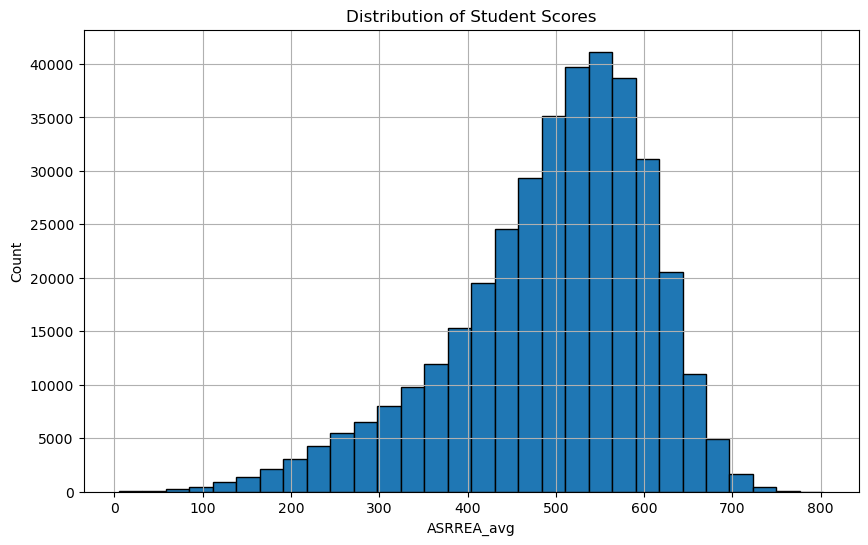

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(df_graph['score'], bins=30, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Student Scores')
plt.xlabel('ASRREA_avg')
plt.ylabel('Count')
plt.grid(True)
plt.show()

The graph illustrates that the most common range for students' overall reading scores falls between 500 and 600, with the median score hovering around approximately 550. This score places students within the High International Benchmark category, indicating a strong performance in reading comprehension on a global scale. However, a noticeable long left tail extends towards scores close to zero, highlighting that a subset of students performed poorly. Turns out that there are many student who performed worse than student 51250010201 from the previous example.


The second graph gives us a peek at how students from 'Russian Federation', 'North Macedonia', 'Abu Dhabi, United Arab Emirates', and 'Morocco' are scoring on the ASRREA_avg. It's pretty cool to see that each country has its own unique pattern going on. This tells us that students in these places are experiencing education differently, maybe because of how schools do things or how much students get into their studies. Diving deeper into what makes each country's scores tick could shed some light on what's working (or not) in their education systems.

As above we first load the data into a dataframe and then plot it.

In [30]:
query_graph_countries = '''
    SELECT S.Student_ID, C.Name, R.Score
    FROM Students AS S
    LEFT JOIN StudentScoreResults AS R ON S.Student_ID = R.Student_ID
    LEFT JOIN StudentScoreEntries AS E ON R.Code = E.Code
    LEFT JOIN Countries AS C ON S.Country_ID = C.Country_ID
    WHERE E.Code = 'ASRREA_avg' AND C.Name IN ('Russian Federation', 'North Macedonia', 'Abu Dhabi, United Arab Emirates', 'Morocco');
'''

df_graph_countries = get_from_db(connection, query_graph_countries)
df_graph_countries

,student_id,name,score
0,64350010101,Russian Federation,594.349886
1,64350010102,Russian Federation,605.772704
2,64350010103,Russian Federation,644.491004
3,64350010104,Russian Federation,553.867962
4,64350010105,Russian Federation,693.930072
...,...,...,...
25539,50452660110,Morocco,505.491280
25540,50452660111,Morocco,600.510254
25541,50452660112,Morocco,507.797848
25542,50452660113,Morocco,645.527376


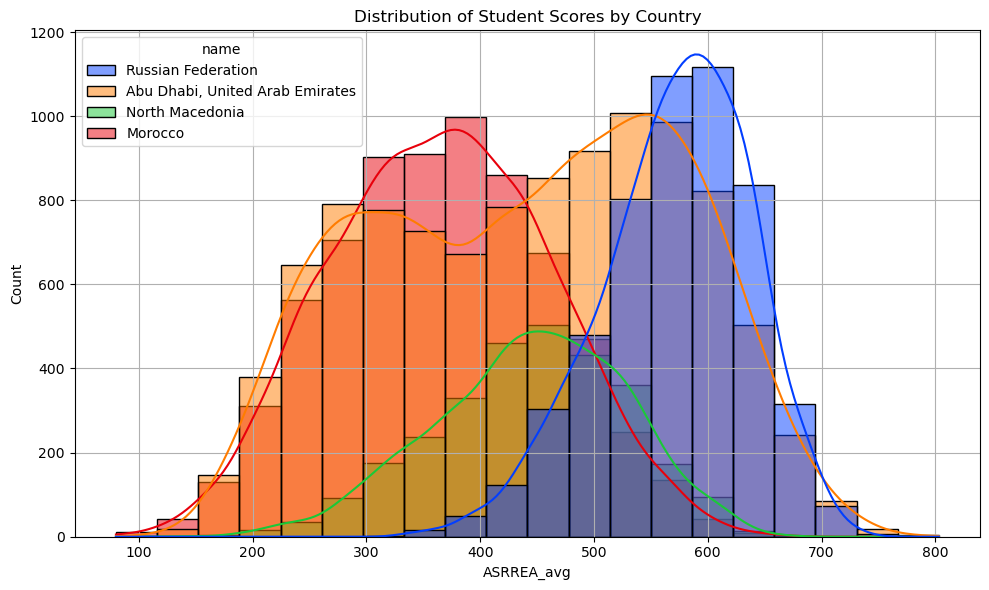

In [31]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(data=df_graph_countries, x='score', hue='name', bins=20, edgecolor='black', kde=True, palette='bright')
plt.title('Distribution of Student Scores by Country')
plt.xlabel('ASRREA_avg')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the legend, if necessary
plt.show()

From this graph, we observe that among this group of countries, students from the 'Russian Federation' have achieved very high scores, with only a few falling below the Low International Benchmark, while many have reached the Advanced Benchmark. For 'North Macedonia', the median score is slightly below the Intermediate Benchmark, indicating a moderate performance overall. In 'Abu Dhabi', the distribution of scores is bimodal, suggesting the presence of two distinct groups of students: one achieving scores at the level of the High International Benchmark and the other significantly below the Low International Benchmark. The poorest performing country is 'Morocco', with its median score falling below the Low International Benchmark, highlighting a need for targeted educational support and interventions to improve student outcomes.

**Excercise:**
- What could be the difference for the two peaks in the distribution for Abu Dhabi?
- What is the distribution for your home country?

Graphs are powerful tools for uncovering fascinating insights, so I highly recommend creating your own and exploring various relationships within the data. Believe me, this dataset is a treasure trove of potential correlations waiting to be discovered through thorough exploration. Diving deep into the data can reveal patterns and connections that might not be immediately obvious, offering valuable perspectives for analysis and decision-making.


### What types of questions to expect during the challenge

Below is the example question that your solutions will need to tackle throughout the challenge, accompanied by SQL query that your model will need to craft to return reliable answers. Developing the ability to construct such query is essential for verifying the accuracy and trustworthiness of your model's responses against the database. By participating in this part of tutorial, you'll not only deepen your understanding of the database's architecture but also sharpen your skills in formulating precise SQL queries.

*Note: The [appendix](#more-example-questions-with-sql-queries) includes additional examples for further exploration at your own pace.*

First, let's break down the process of crafting a query to answer a specific question into several manageable steps. This structured approach will serve as a valuable template for you to efficiently develop your own queries in the future. Pay close attention to each step:

1. **Question Analysis** - Begin by thoroughly reading the question. Reflect on its core objectives and the specific information it seeks from the database. Understanding the question's essence is crucial for determining the direction of your query.

2. **Table Selection** - Once you have a clear understanding of the question, identify where the required information resides within the database. Determine which tables contain the relevant data and consider how they might need to interact to provide the answers you're looking for.

3. **Query Development** - With the target tables identified, you can now focus on constructing the query. This step involves selecting the appropriate fields, specifying conditions, and possibly joining tables to extract the desired information. Depending on your proficiency with SQL, you may choose to build your query incrementally, testing each part as you go, or you might draft it in one go if you're more experienced.

This methodical approach not only streamlines the query development process but also enhances your ability to tackle complex questions with confidence.

#### Example Question 1: "Which country had all schools closed for more than eight weeks?"

Using the above approahc, we get:

##### 1. **Question Analysis**
The objective is to identify countries where all schools experienced closures for more than eight weeks due to the COVID-19 pandemic. This requires analyzing responses from the school questionnaire, specifically focusing on the question regarding the duration of disruptions to normal school operations.

##### 2. **Table Selection**
To extract the necessary information, we'll utilize the following tables:
- `Countries`: Contains information about the countries that participated in PIRLS 2021,
- `Schools`: Holds details about schools, including which country each school is located in,
- `School questionnaire entries`: Stores questions from the school questionnaire,
- `School questionnaire answers`: Contains the responses to the school questionnaire questions.

##### 3. **Query Development**


To find the question in the school questionnaire that is related to school closures, you can start by retrieving the available types of questions to narrow down your investigation. This can be done by querying the `SchoolQuestionnaireEntries` table to list the distinct types of questions. Here's the SQL query you can use:

```sql
SELECT DISTINCT Type FROM SchoolQuestionnaireEntries;
```

In [32]:
query_types = '''
    SELECT DISTINCT Type FROM SchoolQuestionnaireEntries;
    '''
df_types = get_from_db(connection, query_types)
df_types

,type
0,Instructional Time
1,Reading in Your School
2,School Emphasis on Academic Success
3,School Enrollment and Characteristics
4,Students’ Literacy Readiness
5,Principal Experience and Education
6,COVID-19 Pandemic
7,Resources and Technology
8,School Discipline and Safety


Having identified 'COVID-19 Pandemic' as a relevant question type from the `SchoolQuestionnaireEntries` table, the next step involves examining the specific questions categorized under this type to select the most suitable one for our analysis. The SQL query below is designed to retrieve all questions related to the 'COVID-19 Pandemic':

```sql
SELECT * FROM SchoolQuestionnaireEntries
WHERE Type = 'COVID-19 Pandemic';```

In [33]:
query_question_covid = '''
    SELECT * FROM SchoolQuestionnaireEntries
    WHERE Type = 'COVID-19 Pandemic';
    '''
df_question_covid = get_from_db(connection, query_question_covid)
df_question_covid

,code,question,type
0,ACBG19,Please estimate the number of weeks during the current academic year where normal primary school operations have been affected by the COVID-19 pandemic.,COVID-19 Pandemic
1,ACBG20,Does your school provide remote instruction or distance learning resources for primary grades when normal school operations are affected by the COVID-19 pandemic?,COVID-19 Pandemic
2,ACBG21A,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Delivery of printed learning materials to students",COVID-19 Pandemic
3,ACBG21B,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Internet-based resources for students",COVID-19 Pandemic
4,ACBG21C,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Access to digital devices for students",COVID-19 Pandemic
5,ACBG21D,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Recommendations for teachers about how to provide online instruction",COVID-19 Pandemic
6,ACBG21E,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Technical support for teachers",COVID-19 Pandemic
7,ACBG21F,"(When normal primary school operations are affected by the COVID-19 pandemic, does your school support remote learning through the following?) Access to digital devices for teachers",COVID-19 Pandemic


Upon reviewing the questions under the 'COVID-19 Pandemic' type, we have identified the specific question that aligns with our research objective. The question of interest is:

> "Please estimate the number of weeks during the current academic year where normal primary school operations have been affected by the COVID-19 pandemic."

The unique identifier (code) for this question within the database is `ACBG19`. This code will be instrumental in querying the `SchoolQuestionnaireAnswers` table to extract the relevant responses from schools.

To discover the range of possible answers to this question, you can utilize the following SQL query. This query is designed to retrieve distinct answers from the `SchoolQuestionnaireAnswers` table for a specific question code, `ACBG19`:

```sql
SELECT DISTINCT Answer 
FROM SchoolQuestionnaireAnswers
WHERE Code = 'ACBG19';
```

In [34]:
query_available_answers = '''
    SELECT DISTINCT(Answer) FROM SchoolQuestionnaireAnswers
    WHERE Code = 'ACBG19';
    '''
df_available_answers = get_from_db(connection, query_available_answers)
df_available_answers

,answer
0,nan
1,Two weeks to four weeks of instruction
2,Five weeks to eight weeks of instruction
3,Normal primary school operations have not been affected by the COVID-19 pandemic
4,Omitted or invalid
5,Less than two weeks of instruction
6,More than eight weeks of instruction


The closest match to "more than eight weeks," as mentioned in our main question, is the answer `More than eight weeks of instruction`.

The previous SQL queries were instrumental in obtaining values for filtering our queries. However, it's now time to delve into the main components of our final query. Here's the first part which demonstrates the correct way to join tables to retrieve data that aligns with our specific interests

The SQL query provided is designed to retrieve answers `More than eight weeks of instruction` to a specific question identified by the code `ACBG19` from the `SchoolQuestionnaireAnswers` table. This question pertains to the impact of the COVID-19 pandemic on school operations. The query not only fetches the answers but also includes related information from associated tables such as `SchoolQuestionnaireEntries`, `Schools`, and `Countries`. 

```sql
SELECT C.Name, S.School_ID, SQA.Code, SQA.Answer FROM SchoolQuestionnaireAnswers AS SQA
JOIN Schools AS S ON S.School_ID = SQA.School_ID
JOIN Countries AS C ON C.Country_ID = S.Country_ID
WHERE SQA.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction';
```
Here's a breakdown of the query's components:

- `SELECT C.Name, S.School_ID, SQA.Code, SQA.Answer`: This line specifies the columns to be retrieved by the query. It selects the country name (`C.Name`), the school ID (`S.School_ID`), the questionnaire code (`SQA.Code`), and the corresponding answer (`SQA.Answer`). This selection aims to provide a comprehensive view of each response, including the geographical location and institutional identifier.

- `FROM SchoolQuestionnaireAnswers AS SQA`: The query starts from the `SchoolQuestionnaireAnswers` table, aliased as `SQA`. This table contains the responses from various schools to the questionnaire, including the answer to the question with the code `ACBG19`.

- `JOIN Schools AS S ON S.School_ID = SQA.School_ID`: The query then joins the `Schools` table (aliased as `S`) to the `SchoolQuestionnaireAnswers` table. This join is based on the `School_ID` column, which is present in both tables. This operation allows the query to include information about the schools that provided each response.

- `JOIN Countries AS C ON C.Country_ID = S.Country_ID`: Next, the query joins the `Countries` table (aliased as `C`) to the `Schools` table. This join is based on the `Country_ID` column, which is present in both tables. This operation enables the inclusion of country-specific information for each school, providing a geographical context to the responses.

- `WHERE SQA.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction'`: The query filters the results to only include responses to the question identified by the code `ACBG19` that specifically indicate a closure period of `More than eight weeks of instruction`. This condition ensures that the query returns data directly relevant to our question of interest.


In [35]:
query_question_answers = '''
    SELECT C.Name, S.School_ID, SQA.Code, SQA.Answer FROM SchoolQuestionnaireAnswers AS SQA
    JOIN Schools AS S ON S.School_ID = SQA.School_ID
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    WHERE SQA.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction';
    '''
df_question_answers = get_from_db(connection, query_question_answers)
df_question_answers

,name,school_id,code,answer
0,"British Columbia, Canada",91355088,ACBG19,More than eight weeks of instruction
1,"British Columbia, Canada",91355096,ACBG19,More than eight weeks of instruction
2,"British Columbia, Canada",91355123,ACBG19,More than eight weeks of instruction
3,"British Columbia, Canada",91355124,ACBG19,More than eight weeks of instruction
4,"British Columbia, Canada",91355184,ACBG19,More than eight weeks of instruction
...,...,...,...,...
4712,Qatar,6345084,ACBG19,More than eight weeks of instruction
4713,Russian Federation,6435030,ACBG19,More than eight weeks of instruction
4714,Russian Federation,6435038,ACBG19,More than eight weeks of instruction
4715,Russian Federation,6435079,ACBG19,More than eight weeks of instruction


The table above has provided us with all the essential information needed to tackle our primary question. Yet, our analysis remains unfinished. 

Next, we need to count the number of schools in each country using the following query:

```sql
SELECT C.Name, COUNT(S.School_ID) AS schools_in_country
FROM Schools AS S
JOIN Countries AS C ON C.Country_ID = S.Country_ID
GROUP BY C.Name;
```

In [36]:
query_countries_schools = '''
    SELECT C.Name, COUNT(S.School_ID) AS schools_in_country
    FROM Schools AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    GROUP BY C.Name;
    '''
df_countries_schools = get_from_db(connection, query_countries_schools)
df_countries_schools

,name,schools_in_country
0,Hong Kong SAR,144
1,"Alberta, Canada",116
2,Italy,164
3,Oman,215
4,Czech Republic,196
...,...,...
60,Morocco,266
61,"Quebec, Canada",112
62,"British Columbia, Canada",179
63,Taiwan,184


The count of schools by country, as previously determined, will aid us in identifying whether all schools in a specific country were closed for more than eight weeks. The next step involves counting the number of schools in each country that responded with "More than eight weeks of instruction."

We can achieve that with that query:
```sql
SELECT C.Name, COUNT(DISTINCT SQA.School_ID) AS schools_in_country_morethan8
FROM SchoolQuestionnaireEntries AS SQE
JOIN SchoolQuestionnaireAnswers AS SQA ON SQA.Code = SQE.Code
JOIN Schools AS S ON S.School_ID = SQA.School_ID
JOIN Countries AS C ON C.Country_ID = S.Country_ID
WHERE SQE.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction'
GROUP BY C.Name
```

In [37]:
query_countries_schools_morethan8 = '''
    SELECT C.Name, COUNT(DISTINCT SQA.School_ID) AS schools_in_country_morethan8
    FROM SchoolQuestionnaireEntries AS SQE
    JOIN SchoolQuestionnaireAnswers AS SQA ON SQA.Code = SQE.Code
    JOIN Schools AS S ON S.School_ID = SQA.School_ID
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    WHERE SQE.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction'
    GROUP BY C.Name
    '''
df_countries_schools_morethan8 = get_from_db(connection, query_countries_schools_morethan8)
df_countries_schools_morethan8

,name,schools_in_country_morethan8
0,"Abu Dhabi, United Arab Emirates",55
1,Albania,21
2,"Alberta, Canada",36
3,Australia,87
4,Austria,110
...,...,...
59,Turkiye,155
60,United Arab Emirates,113
61,United Kingdom,59
62,United States,50


In the final step we just need to count percentage of schools in countries which answered "More than eight weeks of instruction", by dividing values calculated in two previous sql queries which are `schools_in_country_more_than8` and `schools_in_country`.
We finally end up with the folloing *simple* query for retrieving answer for the question:
> Which country had all schools closed for more than eight weeks?

```sql
    WITH schools_all AS (
    SELECT C.Name, COUNT(S.School_ID) AS schools_in_country
    FROM Schools AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    GROUP BY C.Name
    ),
    schools_closed AS (
        SELECT C.Name, COUNT(DISTINCT SQA.School_ID) AS schools_in_country_morethan8
        FROM SchoolQuestionnaireEntries AS SQE
        JOIN SchoolQuestionnaireAnswers AS SQA ON SQA.Code = SQE.Code
        JOIN Schools AS S ON S.School_ID = SQA.School_ID
        JOIN Countries AS C ON C.Country_ID = S.Country_ID
        WHERE SQE.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction'
        GROUP BY C.Name
    ),
    percentage_calc AS (
        SELECT A.Name, schools_in_country_morethan8 / schools_in_country::float * 100 AS percentage
        FROM schools_all A
        JOIN schools_closed CL ON A.Name = CL.Name
    )
    SELECT *
    FROM percentage_calc
    WHERE percentage = 100;
```

Here's a breakdown of the new query's components:

The `percentage_calc` Common Table Expression (CTE) calculates the percentage of schools in each country that were closed for more than eight weeks. It does this by dividing the count of distinct schools that answered "More than eight weeks of instruction" (`schools_in_country_morethan8`) by the total count of schools in the country (`schools_in_country`). This result is then multiplied by 100 to convert it into a percentage format. The calculation involves a join between two previously defined CTEs: `schools_all` and `schools_closed`. The join is made on the country name (`A.Name = CL.Name`), ensuring that the calculation is done per country.

The final `SELECT` statement retrieves all records from the `percentage_calc` CTE where the calculated percentage equals 100. This effectively filters the results to only include countries where 100% of the schools were reported to be closed for more than eight weeks, answering the question: "Which country had all schools closed for more than eight weeks?"

In [38]:
query = '''
    WITH schools_all AS (
    SELECT C.Name, COUNT(S.School_ID) AS schools_in_country
    FROM Schools AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    GROUP BY C.Name
    ),
    schools_closed AS (
        SELECT C.Name, COUNT(DISTINCT SQA.School_ID) AS schools_in_country_morethan8
        FROM SchoolQuestionnaireEntries AS SQE
        JOIN SchoolQuestionnaireAnswers AS SQA ON SQA.Code = SQE.Code
        JOIN Schools AS S ON S.School_ID = SQA.School_ID
        JOIN Countries AS C ON C.Country_ID = S.Country_ID
        WHERE SQE.Code = 'ACBG19' AND SQA.Answer = 'More than eight weeks of instruction'
        GROUP BY C.Name
    ),
    percentage_calc AS (
        SELECT A.Name, schools_in_country_morethan8 / schools_in_country::float * 100 AS percentage
        FROM schools_all A
        JOIN schools_closed CL ON A.Name = CL.Name
    )
    SELECT *
    FROM percentage_calc
    WHERE percentage = 100;
    '''
df = get_from_db(connection, query)
df

,name,percentage
0,Czech Republic,100.0


The results reveal that in the Czech Republic, all schools were closed for more than eight weeks, delivering the precise answer we were seeking. 

This outcome underscores that arriving at such a response was neither simple nor direct but necessitated a thorough analysis. Such depth of investigation is feasible only with a comprehensive understanding of the database contents, highlighting the importance of familiarity with the data at hand. This case exemplifies how detailed data exploration and adept query formulation can unveil critical insights, demonstrating the value of in-depth data analysis in extracting meaningful information.

### Key insights

- **Query Construction Skills**: Developing the skill to formulate precise queries tailored to specific questions is vital for effective data analysis. Crafting accurate and efficient SQL queries is essential not only for extracting meaningful insights but also for determining whether your solution is producing reliable results. This approach ensures you have a clear understanding of whether the model is hallucinating, thereby assessing its trustworthiness.

- **Data Understanding Tools**: Enhancing your understanding of the data can significantly benefit from visualization libraries such as seaborn and matplotlib. These tools and libraries offer powerful ways to manipulate, explore, and visualize data, making complex datasets more accessible and insights more apparent.

By dedicating time to comprehend the database, honing your query construction skills, and leveraging data manipulation and visualization tools, you can unlock valuable insights from the data and drive more informed decision-making.


### Exercises

Now it's time for you to put your skills to the test by constructing SQL queries tailored to specific questions. Below, you'll find three example questions. They are organized in order of increasing complexity, from the simplest to the most challenging, to help you gradually build your query development skills.

*This space is designed for exploration and creativity. You are encouraged to add new code cells, create various graphs, and experiment with different data analysis techniques. Dive deep into the data, uncover hidden insights, and showcase your findings in innovative ways. This is your playground for data understanding and visualization.*

#### 1. What was Egypt's average score for fourth graders in reading?

In [28]:
query_question1 = '''
        Here is the place for your sql query
'''
# Uncomment the lines below to check if your query is working properly

# question1_df = get_from_db(connection, query_question1)
# question1_df

#### 2. What percentage of students in Germany met the high reading standards?

In [29]:
query_question2 = '''
        Here is the place for your sql query
'''
# Uncomment the lines below to check if your query is working properly

# question2_df = get_from_db(connection, query_question2)
# question2_df

#### 3. How many countries reported that at least 85% of their students reached the Low International Benchmark?

In [30]:
query_question3 = '''
        Here is the place for your sql query
'''
# Uncomment the lines below to check if your query is working properly

# question3_df = get_from_db(connection, query_question3)
# question3_df

## Conclusion

In this tutorial, we learned a lot about the data we're dealing with. We understood the structure of the database, saw examples of the content and how to access.

To be successful, you, or rather your AI system, will need this understanding.
And that's exactly what we'll cover in the next tutorials. 
- [Tutorial 3](https://github.com/cg-gdsc/GDSC-7/blob/main/tutorials/Tutorial_3_Introduction_to_AI_Agents.ipynb) explains agentic systems and how to build them, i.e. the "Hello World" of GenAI applications
- [Tutorial 4](https://github.com/cg-gdsc/GDSC-7/blob/main/tutorials/Tutorial_4_Submitting_Your_Solution.ipynb) shows to adapt the ideas to our problem and how to submit your first solution!

And before we leave, a quick reminder that if you are ever stuck, do reach out to us on [Teams](https://teams.microsoft.com/l/team/19%3a4017a2e9af4942e7aa157d6ec9d751b4%40thread.skype/conversations?groupId=7d77d672-dff1-4c9f-ac55-3c837c1bebf9&tenantId=76a2ae5a-9f00-4f6b-95ed-5d33d77c4d61/). You can also ask the AI to help you, this is particularly useful when writing and debugging code!

Let's go!

## Appendix

In the appendix we'll show you a nice tool that helps with data manipulation and a few more example questions.

### VS Code

If you prefer using VS Code over SageMaker, there's a bonus extension for data manipulation that I highly recommend to install. While it's entirely optional, I strongly encourage you to explore this extension on your own.

#### Data Wrangler

I'd like to introduce you to a fantastic VS Code extension that significantly enhances data analysis. This extension offers a comprehensive user interface for data viewing and analysis, presents detailed column statistics, provides visualizations, and automatically generates Pandas code during data cleaning and transformation processes.

To install, simply click on the `Extensions` icon in the left sidebar, search for `Data Wrangler`, and then click `Install`. That's all there is to it! For those interested in exploring this tool, detailed documentation on how to utilize Data Wrangler can be found [here](https://code.visualstudio.com/docs/datascience/data-wrangler).

![title](../images/t2_data_wrangler.png)

### More example questions with sql queries

Here are a few more example of the types of question you can expect. You can also see the complete list on the arena section of the GDSC homepage.

#### Question: "Which country had an average reading score between 549 and 550 for its students?"


In [39]:
query1 = '''
    SELECT C.Name AS Country
    FROM Students as S
    JOIN Countries as C ON S.Country_ID = C.Country_ID
    JOIN StudentScoreResults SSR ON S.Student_ID = SSR.Student_ID
    WHERE SSR.Code = 'ASRREA_avg'
    GROUP BY C.Name
    HAVING AVG(ssr.Score) BETWEEN 549 AND 550;
'''

df1 = get_from_db(connection, query1)
df1

,country
0,Finland


#### Question: "What percentage of students in the UAE met the minimum reading standards?"


In [40]:
query2 = '''
    WITH benchmark_score AS (
        SELECT Score FROM Benchmarks
        WHERE Name = 'Low International Benchmark'
    )
    SELECT SUM(CASE WHEN SSR.Score >= bs.Score THEN 1 ELSE 0 END) / COUNT(*)::float as percentage
    FROM Students AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    JOIN StudentScoreResults AS SSR ON SSR.Student_ID = S.Student_ID
    CROSS JOIN benchmark_score AS bs
    WHERE C.Name LIKE '%United Arab Emirates%' AND SSR.Code = 'ASRREA_avg'
'''

df2 = get_from_db(connection, query2)
df2

,percentage
0,0.731247


#### Question: "What was Turkey's average score for fourth graders in reading?"

In [41]:
query3 = '''
    SELECT C.Name, AVG(SSR.score)
    FROM Students AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    JOIN StudentScoreResults AS SSR ON SSR.Student_ID = S.Student_ID
    WHERE SSR.Code = 'ASRREA_avg' AND C.Name = 'Turkiye'
    GROUP BY C.Name
'''

df3 = get_from_db(connection, query3)
df3

,name,avg
0,Turkiye,502.732337


#### Question: "In which country did the most students participate in the survey?"

In [42]:
query4 = '''
    SELECT C.Name, COUNT(*)
    FROM Students AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    GROUP BY C.Name
    ORDER BY 1
    LIMIT 1
'''

df4 = get_from_db(connection, query4)
df4

,name,count
0,"Abu Dhabi, United Arab Emirates",10381


#### Question: "How do the reading skills of countries in the Middle East compare to each other? Can you list them starting with the best down to the worst?"

In [43]:
query5 = '''
    SELECT C.name, AVG(SSR.Score)
    FROM Students AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    JOIN StudentScoreResults AS SSR ON SSR.Student_ID = S.Student_ID
    WHERE SSR.Code = 'ASRREA_avg' AND C.Name IN (
        'Dubai, United Arab Emirates',
        'Israel',
        'Qatar',
        'Bahrain',
        'United Arab Emirates',
        'Saudi Arabia',
        'Abu Dhabi, United Arab Emirates',
        'Oman',
        'Iran, Islamic Rep. of',
        'Jordan'
    )
    GROUP BY C.Name
    ORDER BY 2 DESC
'''

df5 = get_from_db(connection, query5)
df5

,name,avg
0,"Dubai, United Arab Emirates",545.444815
1,Israel,510.975563
2,Qatar,485.253194
3,United Arab Emirates,476.708137
4,Bahrain,451.357219
5,Saudi Arabia,448.693415
6,"Abu Dhabi, United Arab Emirates",441.211484
7,Oman,428.598942
8,"Iran, Islamic Rep. of",422.423009
9,Jordan,370.310148


#### Question: "What percentage of students in Egypt reached the Low International Benchmark?"

In [44]:
query6 = '''
    WITH benchmark_score AS (
        SELECT Score FROM Benchmarks
        WHERE Name = 'Low International Benchmark'
    )
    SELECT SUM(CASE WHEN SSR.score >= bs.Score THEN 1 ELSE 0 END) / COUNT(*)::float as percentage
    FROM Students AS S
    JOIN Countries AS C ON C.Country_ID = S.Country_ID
    JOIN StudentScoreResults AS SSR ON SSR.Student_ID = S.Student_ID
    CROSS JOIN benchmark_score AS bs
    WHERE C.Name = 'Egypt' AND SSR.Code = 'ASRREA_avg'
'''

df6 = get_from_db(connection, query6)
df6

,percentage
0,0.42875


#### Question: "What is the total number of students who took part in surveys in France?"

In [45]:
query7 = '''
    SELECT COUNT(DISTINCT S.Student_ID)
    FROM students AS S
    JOIN countries AS C ON C.Country_ID = S.Country_ID
    WHERE C.Name = 'France';
'''

df7 = get_from_db(connection, query7)
df7

,count
0,5339


## Closing connection to database

In [ ]:
response = input('Are you sure you want to close the connection? [Y/N]').strip().lower()
if response == 'y':
    with connection:
        connection.close()